# Introduction
The clustering algorithm requires parameters for DBSCAN as well as other temporal parameters. This notebook is used to test different parameters for the clustering algorithm.

### Imports
Import libraries and write settings here.

In [4]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/DynCondPaper'

### Style settings

In [5]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [6]:
def dist_vs_idx_dist(com_arr):
    sep_mat = np.linalg.norm(com_arr[:, np.newaxis, :] - com_arr[np.newaxis, :, :], axis=2)
    avg_dist_arr = np.zeros((sep_mat.shape[0]))
    avg_dist_sem_arr = np.zeros((sep_mat.shape[0]))
    for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr[i] = diag.mean()
        avg_dist_sem_arr[i] = stats.sem(diag)
    return avg_dist_arr, avg_dist_sem_arr
    

def sd_num(h5_data):
    ydict = yaml.safe_load(h5_data.attrs['RunConfig'])
    return ydict['rngSeed']

# Single snapshot clusters

## Single crosslinker filaments

number of estimated clusters : 2
number of thresholded clusters : 0


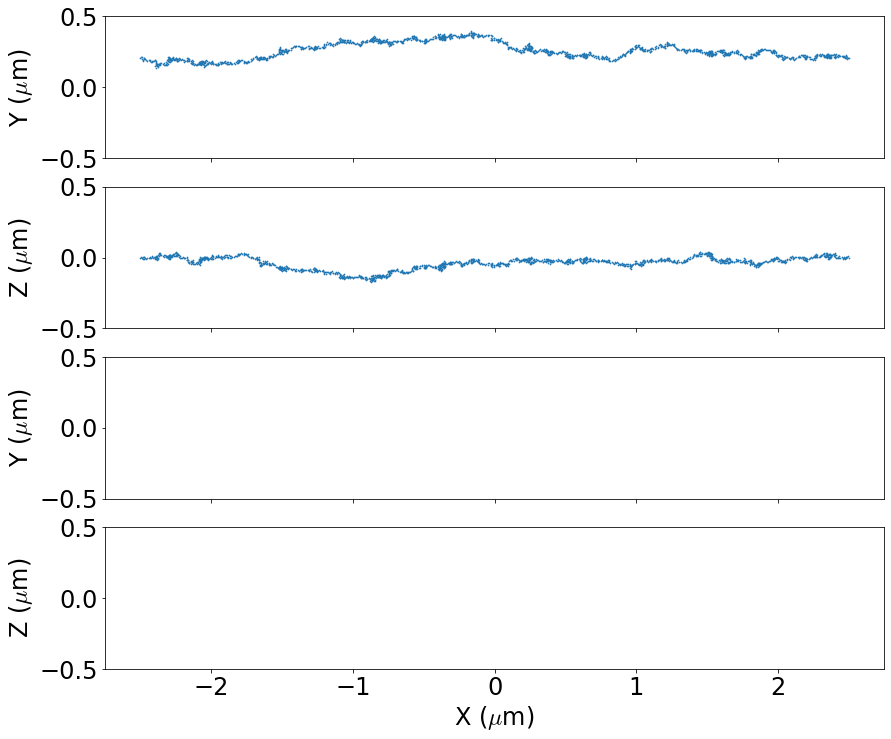

In [43]:
data_path = (ceph_path / "23-10-16_aLc1_scan8.12_line1600_5umPin_Ke.1-300/simulations/Ke300/s1")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
time_ind = -100

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, time_ind], eps=.020, min_samples=20, thresh=40)
    
    
    _ = cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,time_ind], clust, cluster_centers, cluster_label_inds)
    _ = axarr[0].set_ylim(-.5, .5)
  

Looks like even for the strongest binding affinity we do not get clusters along the backbone of the filament at least at this stretch. This was not what I was expecting. You see that the filament has some smaller 'clusters' but they don't pass the 40 bead threshold. I'm wondering if that is too strict of a cutoff. I'm not sure if there is a better way to characterize this. Reducing this threshold would allow us to see more clusters but I worry they would be highly transient. I can always run the analysis again but with a different set of analysis parameters. I think I just need to pick one and go for it though. Still for thoroughness I want to see what happens if I reduce the $K_e$ and see if clusters form.

number of estimated clusters : 2
number of thresholded clusters : 0


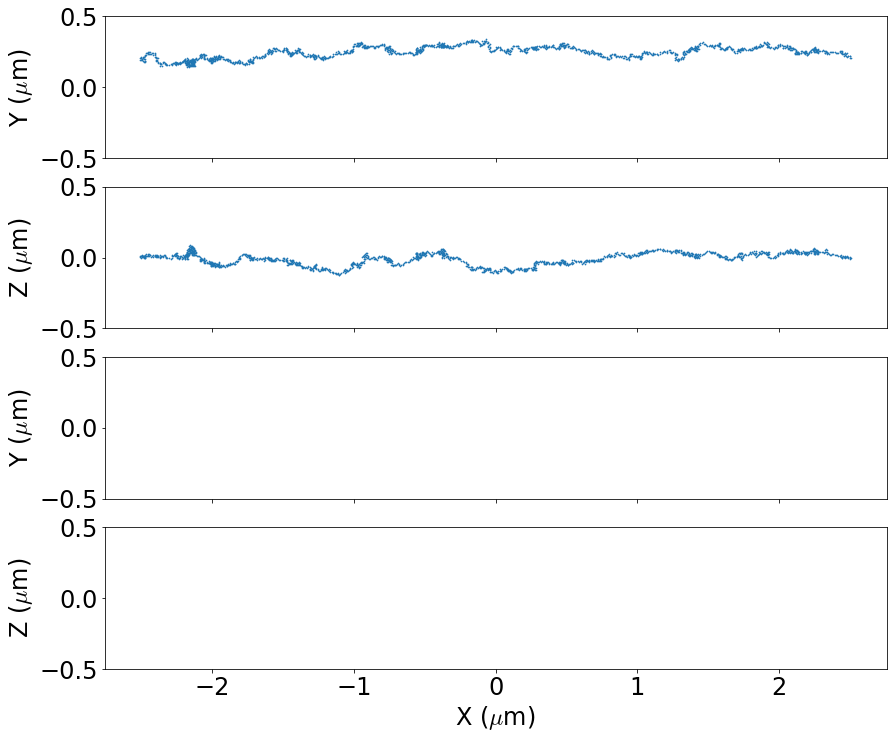

In [58]:
data_path = (ceph_path / "23-10-16_aLc1_scan8.12_line1600_5umPin_Ke.1-300/simulations/Ke30/s1")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
time_ind = -100

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, time_ind], eps=.020, min_samples=20, thresh=30)
    
    
    _ = cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,time_ind], clust, cluster_centers, cluster_label_inds)
    _ = axarr[0].set_ylim(-.5, .5)
  

There are small transient clusters forming here but that is not much different from what we see in the larger simulations. Ok, let's go to the on step lower on the $K_e$ scale and see what happens

number of estimated clusters : 0
number of thresholded clusters : 0


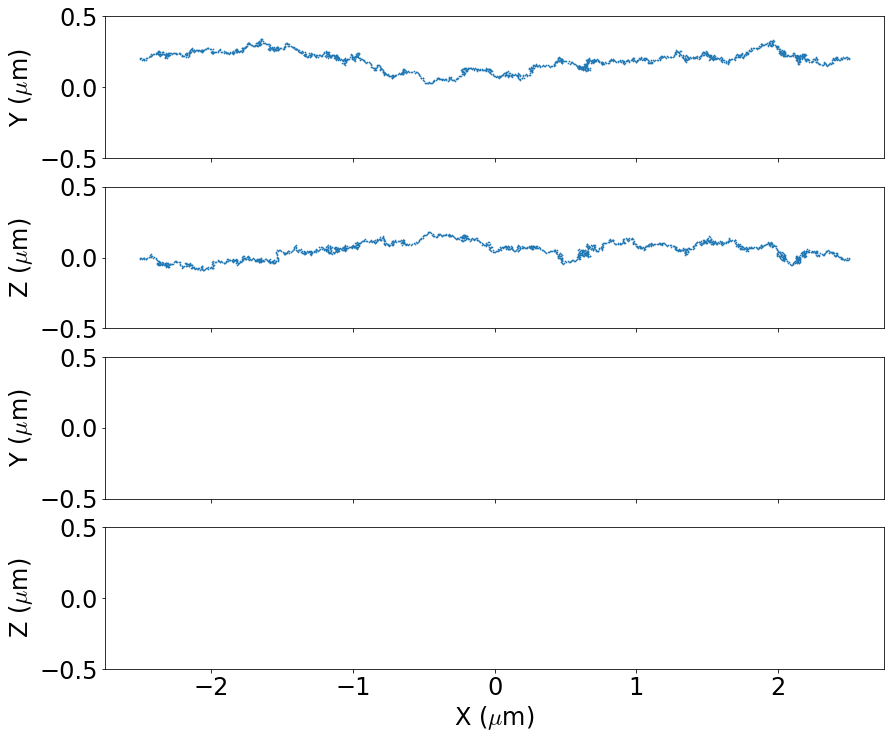

In [59]:
data_path = (ceph_path / "23-10-16_aLc1_scan8.12_line1600_5umPin_Ke.1-300/simulations/Ke10/s1")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
time_ind = -10

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, time_ind], eps=.020, min_samples=20, thresh=30)
    
    
    _ = cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,time_ind], clust, cluster_centers, cluster_label_inds)
    _ = axarr[0].set_ylim(-.5, .5)

Again, not much.

## 2x sticky number filaments

number of estimated clusters : 2
number of thresholded clusters : 2


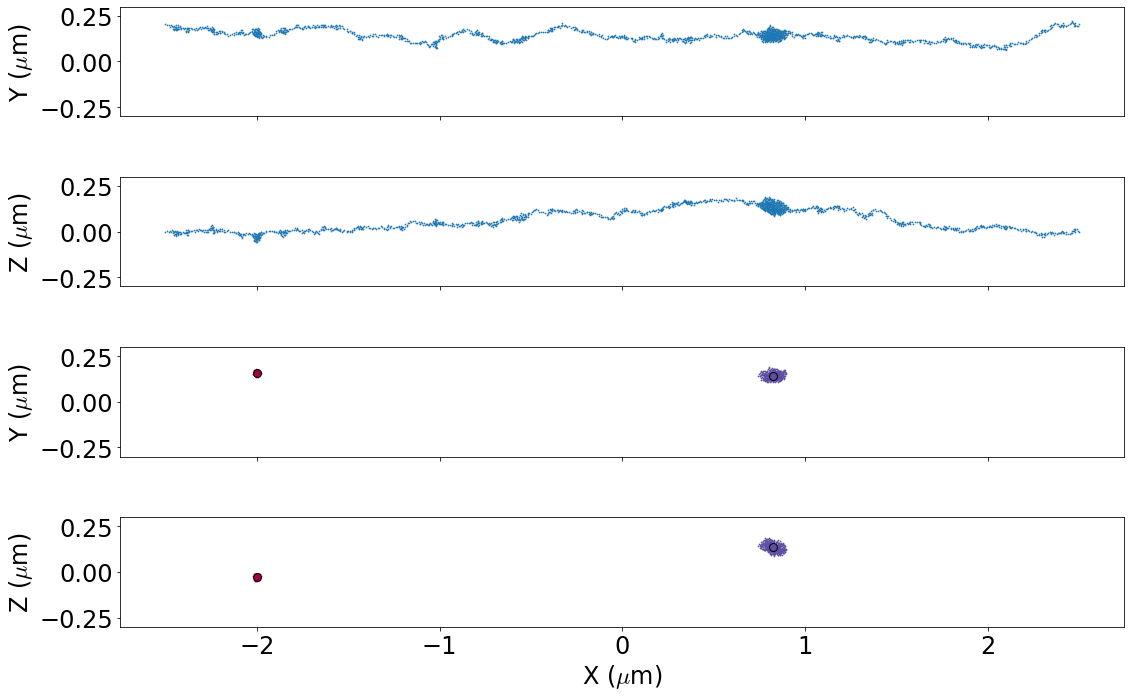

In [66]:
data_path = (ceph_path /"23-10-17_aLc1_scan8.12_line1600_5umPin_2xKe.1-300/simulations/Ke30/s1/")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
time_ind = -1

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, time_ind], eps=.020, min_samples=20, thresh=1)
    
    
    _ = cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,time_ind], clust, cluster_centers, cluster_label_inds)
    _ = axarr[0].set_ylim(-.3, .3)
  

We finally see an undeniable cluster in this simulation. Let's see if this is true for another seed.

number of estimated clusters : 9
number of thresholded clusters : 9


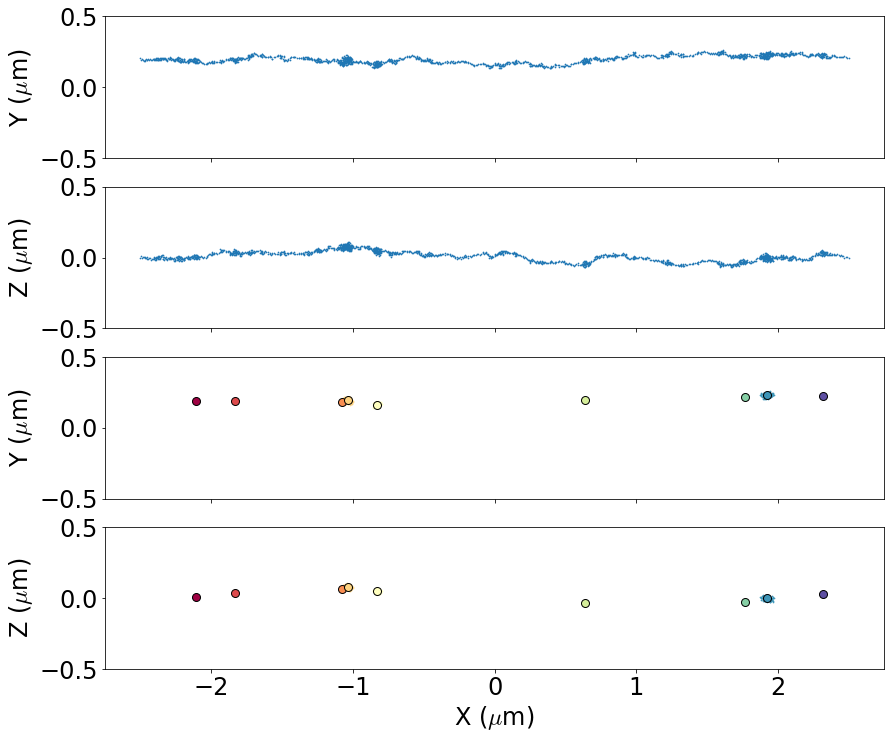

In [65]:
data_path = (ceph_path /"23-10-17_aLc1_scan8.12_line1600_5umPin_2xKe.1-300/simulations/Ke30/s6/")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
time_ind = -100

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, time_ind], eps=.02, min_samples=20, thresh=1)
    
    
    _ = cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,time_ind], clust, cluster_centers, cluster_label_inds)
    _ = axarr[0].set_ylim(-.5, .5)
  

There are definitely clusters here though some of them I might consider to be too small to be considered a cluster. There is even a cluster that seem to be broken up. It is easier to threshold away the smaller clusters when I make the lineage trees but I'm not sure how to handle the split cluster now. What if I increase the eps to 0.025? 

number of estimated clusters : 18
number of thresholded clusters : 18


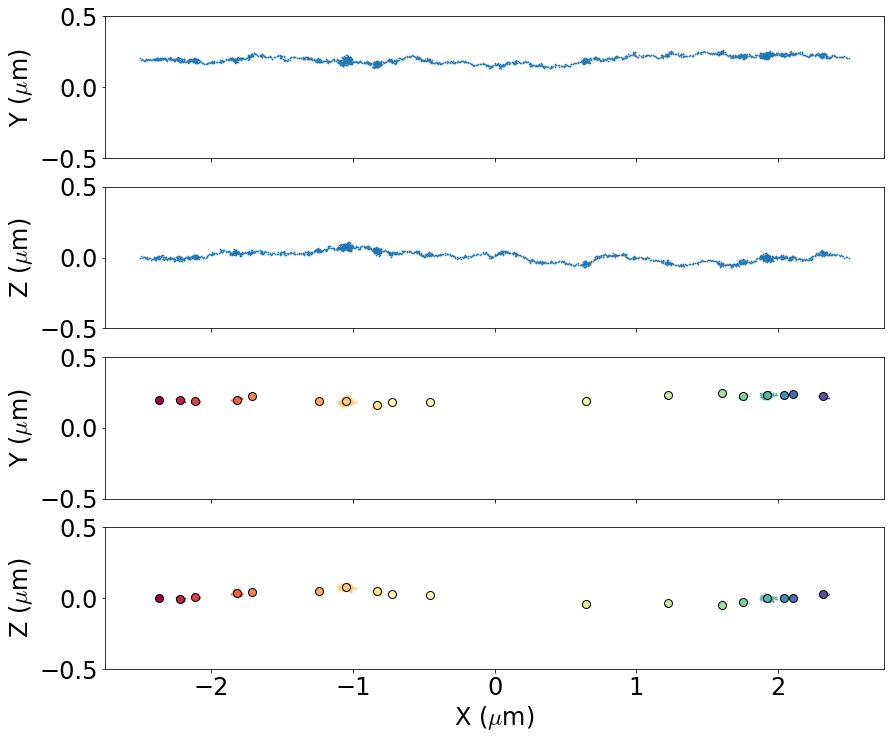

In [72]:
data_path = (ceph_path /"23-10-17_aLc1_scan8.12_line1600_5umPin_2xKe.1-300/simulations/Ke30/s6/")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
time_ind = -100

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, time_ind], eps=.025, min_samples=20, thresh=1)
    
    
    _ = cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,time_ind], clust, cluster_centers, cluster_label_inds)
    _ = axarr[0].set_ylim(-.5, .5)
  

There are certainly more clusters now. The large one also merged from what I can see. However, these I'm guessing are going to be mostly noise. I can simply threshold away the smaller clusters but that could definitely come back to bite me I think. There has to be a more rational approach to figuring out the parameters for DBSCAN. I could probably use the random packing of spheres to figure out what a dense cluster of spheres would be. From there, what do I choose as my number of neighbors? Well actually what I would do is use that to define a radius, the eps, and then calculate what the number of neighbors would be for sphere on the perifory... I think. Might want to run this by someone to double check my logic.

number of estimated clusters : 7
number of thresholded clusters : 3


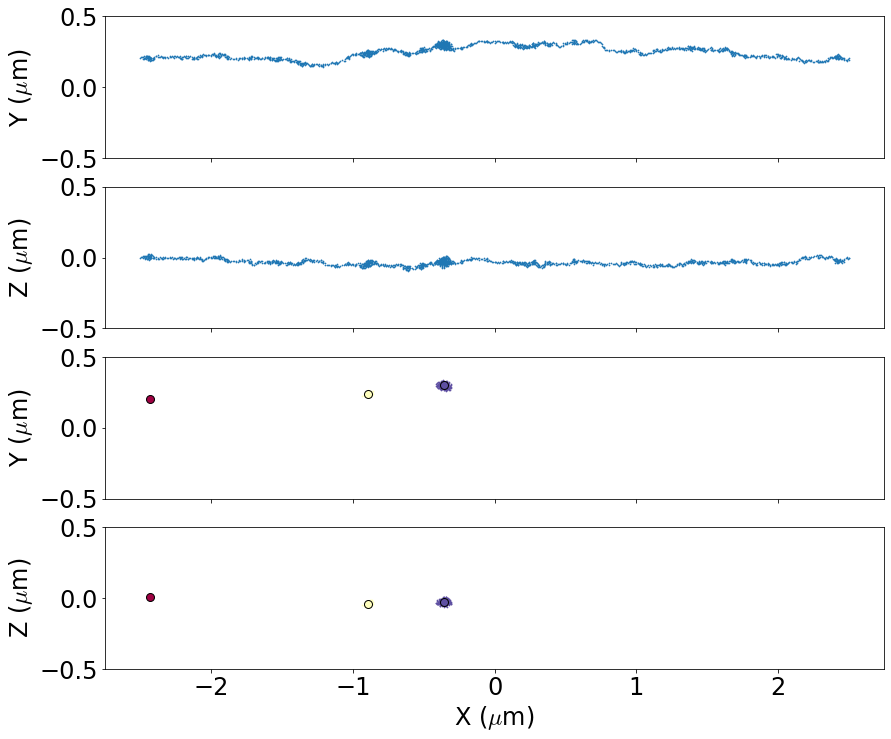

In [62]:
data_path = (ceph_path /"23-10-17_aLc1_scan8.12_line1600_5umPin_2xKe.1-300/simulations/Ke100/s6/")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
time_ind = -300

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr[:, :, time_ind], eps=.02, min_samples=20, thresh=20)
    
    
    _ = cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,time_ind], clust, cluster_centers, cluster_label_inds)
    _ = axarr[0].set_ylim(-.5, .5)
  

# DBSCAN characterization

In [ ]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    eps = np.arange(.025, .105, .005)
    min_sample = np.arange(4, 52, 2)
    clust_num_mat = np.zeros((eps.size, min_sample.size))
    beads_in_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_bead_per_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_rog_mat = np.zeros((eps.size, min_sample.size))
    for i, e in enumerate(eps):
        for j, m in enumerate(min_sample):
            # print(f"i={i}, j={j}")
            clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
                com_arr[:, :, -1], eps=e, min_samples=m, thresh=1, verbose=False)
            clust_num_mat[i,j] = len(cluster_centers)
            if clust_num_mat[i,j] == 0:
                beads_in_clust_mat[i,j] = 0
                avg_bead_per_clust_mat[i,j] = 0
                avg_rog_mat[i,j] = np.nan
                continue
            beads_in_clust_mat[i,j] = sum([len(cli) for cli in cluster_label_inds])
            avg_bead_per_clust_mat[i,j] = np.mean([len(cli) for cli in cluster_label_inds])
            avg_rog_mat[i,j] = np.mean([ca.calc_rad_of_gyration(com_arr[cli,:,end_ind,np.newaxis])/np.cbrt(len(cli)) for cli in cluster_label_inds]) 


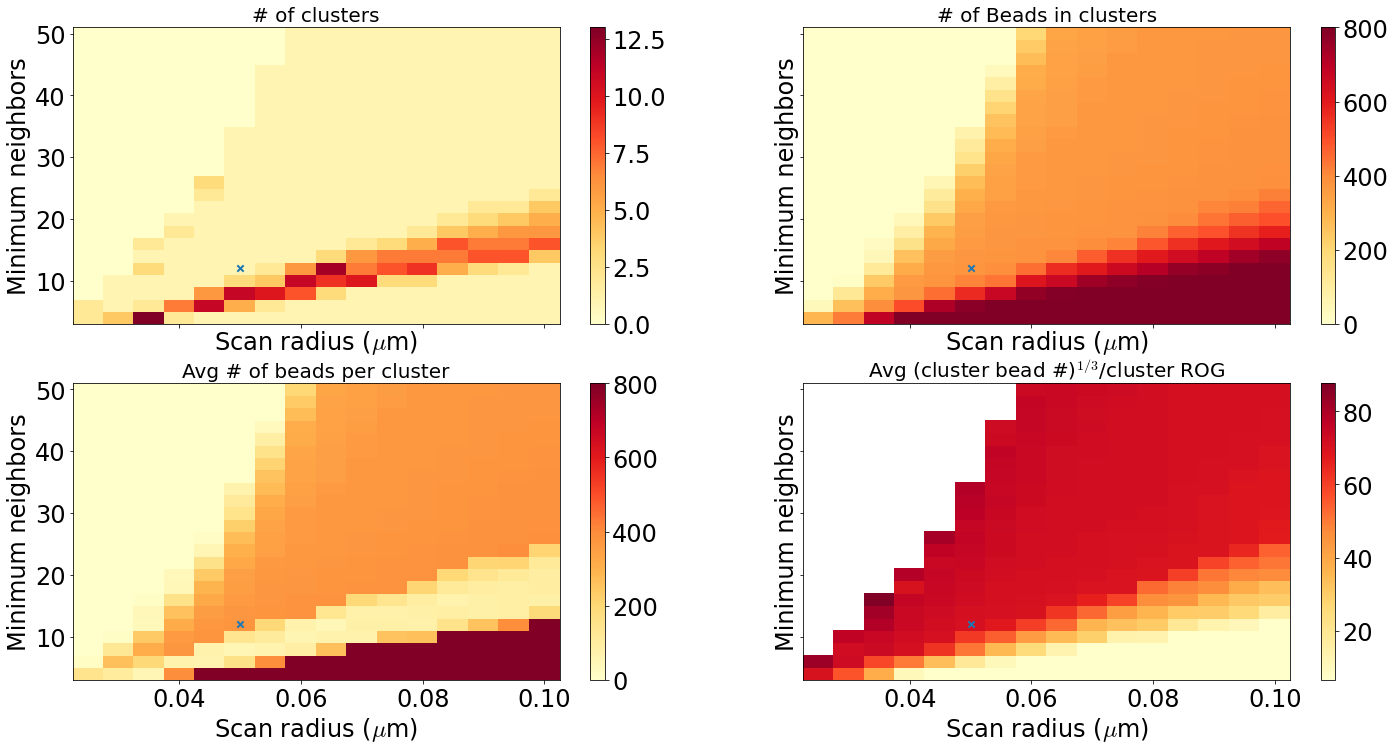

In [26]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulatvions/s6")
ss_ind = 1
end_ind = 500
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()

X, Y = np.meshgrid(eps, min_sample)
plt.rcParams['pcolor.shading'] = 'auto'
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
c3 = axarr[3].pcolor(X,Y, 1./(avg_rog_mat.T))
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
cbar3 = fig.colorbar(c3, ax=axarr[3])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
_ = axarr[3].set_title('Avg (cluster bead #)$^{1/3}$/cluster ROG')
for ax in axarr:
    _ = ax.scatter(.05, 12, s=40, marker='x')
    _ = ax.set_xlabel('Scan radius ($\mu$m)')
    _ = ax.set_ylabel('Minimum neighbors')
            



This was the old data set with the blue x's being the parameters I thought gave the best looking clusters. What I see I was trying to optimize for was a large number of clusters while also keeping the average number of beads per cluster high. This did not maximize the total number of beads in clusters but it did give a large average (volume)^{1/3} to radius of gyration ratio. This tells us that the clusters are more spherical in the optimal parameter case so we don't have long trailing clusters.

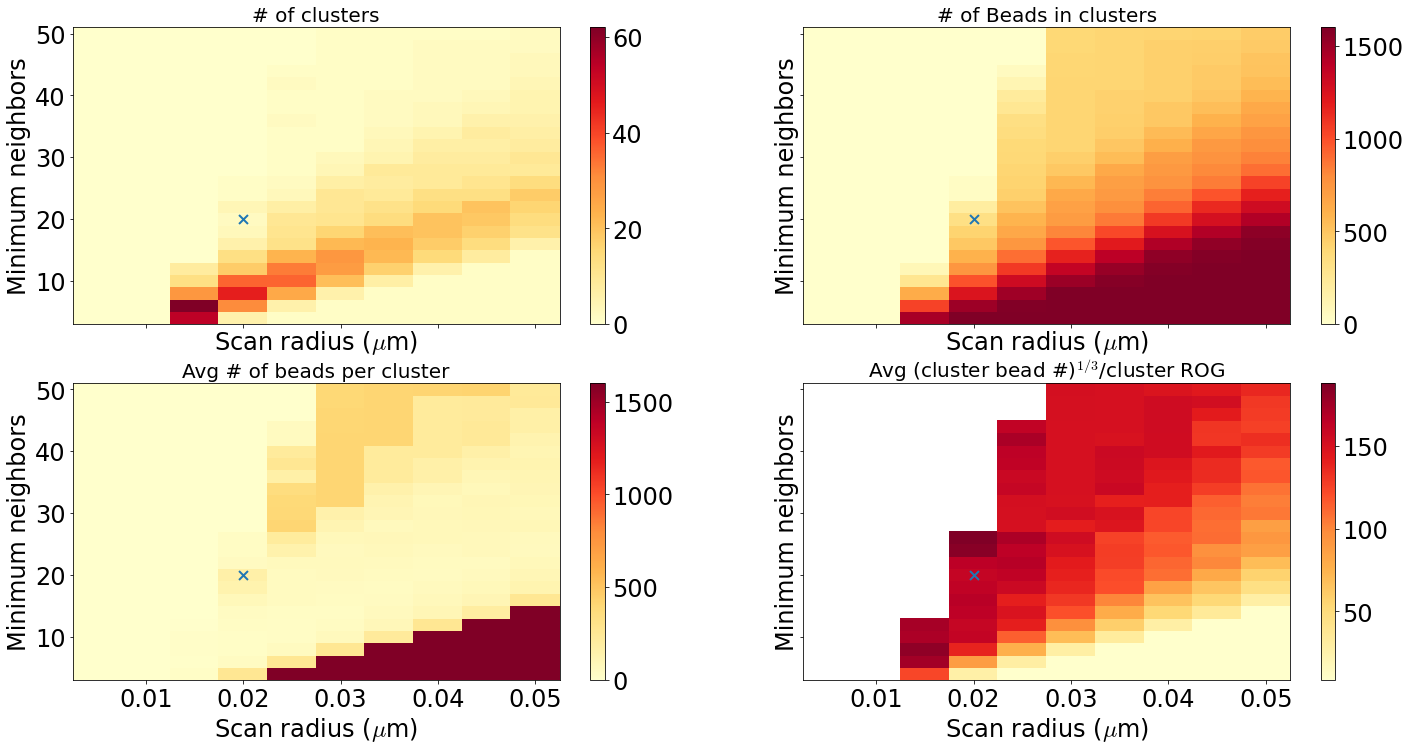

In [77]:
data_path = (ceph_path /"23-10-17_aLc1_scan8.12_line1600_5umPin_2xKe.1-300/simulations/Ke30/s1/")
ss_ind = 1
end_ind = -1
start_bead = 0
n_skip = 10
end_bead = None

fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind:n_skip]

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind:n_skip]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    eps = np.arange(.005, .055, .005)
    min_sample = np.arange(4, 52, 2)
    clust_num_mat = np.zeros((eps.size, min_sample.size))
    beads_in_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_bead_per_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_rog_mat = np.zeros((eps.size, min_sample.size))
    for i, e in enumerate(eps):
        for j, m in enumerate(min_sample):
            # print(f"i={i}, j={j}")
            clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
                com_arr[:, :, -1], eps=e, min_samples=m, thresh=1, verbose=False)
            clust_num_mat[i,j] = len(cluster_centers)
            if clust_num_mat[i,j] == 0:
                beads_in_clust_mat[i,j] = 0
                avg_bead_per_clust_mat[i,j] = 0
                avg_rog_mat[i,j] = np.nan
                continue
            beads_in_clust_mat[i,j] = sum([len(cli) for cli in cluster_label_inds])
            avg_bead_per_clust_mat[i,j] = np.mean([len(cli) for cli in cluster_label_inds])
            avg_rog_mat[i,j] = np.mean([ca.calc_rad_of_gyration(com_arr[cli,:,end_ind,np.newaxis])/np.cbrt(len(cli)) for cli in cluster_label_inds]) 

    
X, Y = np.meshgrid(eps, min_sample)
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
c3 = axarr[3].pcolor(X,Y, 1/avg_rog_mat.T)
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
cbar3 = fig.colorbar(c3, ax=axarr[3])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
_ = axarr[3].set_title('Avg (cluster bead #)$^{1/3}$/cluster ROG')
for ax in axarr:
    _ = ax.scatter(.02, 20, s=80, marker='x')
    _ = ax.set_xlabel('Scan radius ($\mu$m)')
    _ = ax.set_ylabel('Minimum neighbors')



With the new parameter sets, I can see I am getting similar results to my last parameter set. There is a little bit of tolerance here but I am rather happy with the results. We will see if the condensates can be tracked through time. One thing I need to be aware of though is that, thresholding cluster sizes after this could dramatically affect the results. For example, if I threshold cluster size to 40, I then get this.

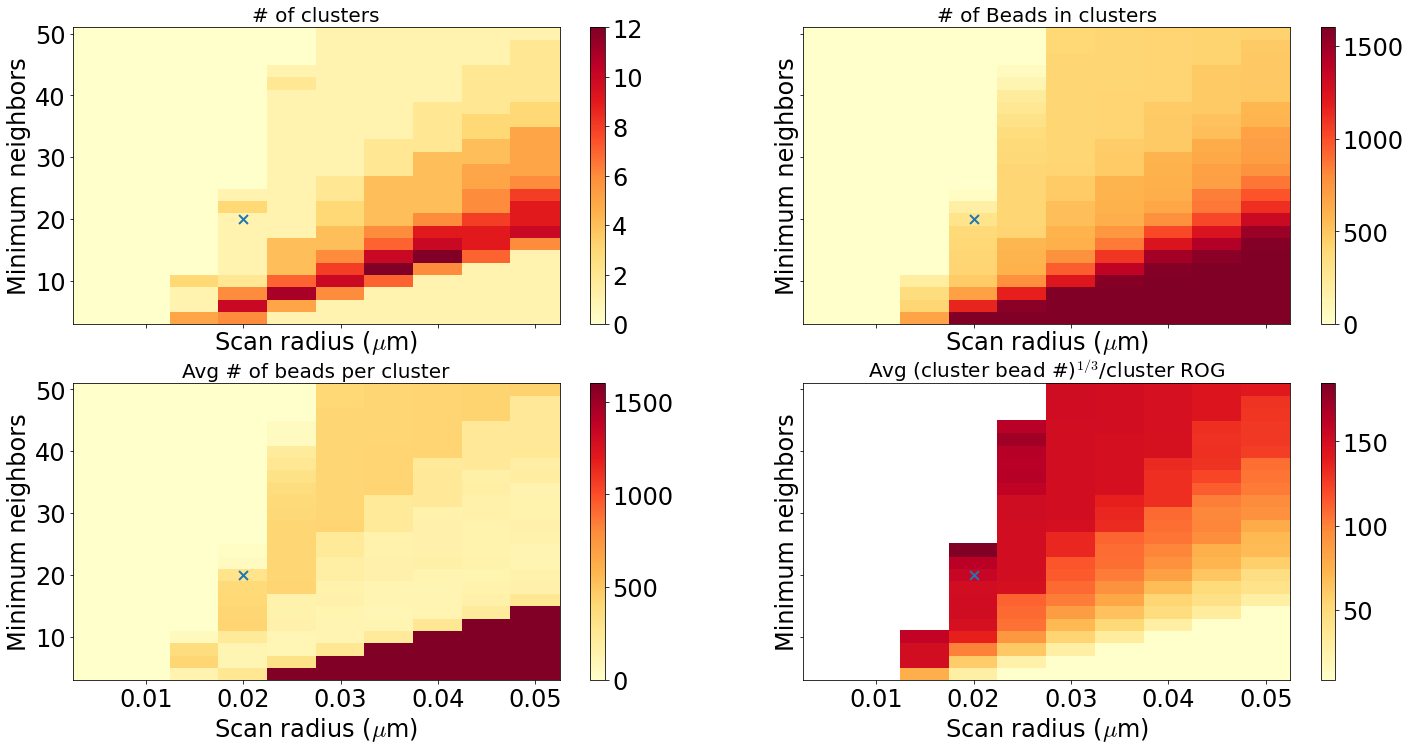

In [79]:
data_path = (ceph_path /"23-10-17_aLc1_scan8.12_line1600_5umPin_2xKe.1-300/simulations/Ke30/s1/")
ss_ind = 1
end_ind = -1
start_bead = 0
n_skip = 10
end_bead = None

fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind:n_skip]

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind:n_skip]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    eps = np.arange(.005, .055, .005)
    min_sample = np.arange(4, 52, 2)
    clust_num_mat = np.zeros((eps.size, min_sample.size))
    beads_in_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_bead_per_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_rog_mat = np.zeros((eps.size, min_sample.size))
    for i, e in enumerate(eps):
        for j, m in enumerate(min_sample):
            # print(f"i={i}, j={j}")
            clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
                com_arr[:, :, -1], eps=e, min_samples=m, thresh=40, verbose=False) # CHANGED THE THRESHOLD HERE
            clust_num_mat[i,j] = len(cluster_centers)
            if clust_num_mat[i,j] == 0:
                beads_in_clust_mat[i,j] = 0
                avg_bead_per_clust_mat[i,j] = 0
                avg_rog_mat[i,j] = np.nan
                continue
            beads_in_clust_mat[i,j] = sum([len(cli) for cli in cluster_label_inds])
            avg_bead_per_clust_mat[i,j] = np.mean([len(cli) for cli in cluster_label_inds])
            avg_rog_mat[i,j] = np.mean([ca.calc_rad_of_gyration(com_arr[cli,:,end_ind,np.newaxis])/np.cbrt(len(cli)) for cli in cluster_label_inds]) 

    
X, Y = np.meshgrid(eps, min_sample)
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
c3 = axarr[3].pcolor(X,Y, 1/avg_rog_mat.T)
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
cbar3 = fig.colorbar(c3, ax=axarr[3])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
_ = axarr[3].set_title('Avg (cluster bead #)$^{1/3}$/cluster ROG')
for ax in axarr:
    _ = ax.scatter(.02, 20, s=80, marker='x')
    _ = ax.set_xlabel('Scan radius ($\mu$m)')
    _ = ax.set_ylabel('Minimum neighbors')



We now see that we slightly increase the avg number of beads in cluster if we move to a scan radius of .025 while maintaining the same number of clusters. The clusters do become slightly more oblong. I think it is a safer choice to increase the scan radius to .025 and then threshold afterwards.